# NIH Chest X-ray Dataset Preprocessing

This notebook focuses on preprocessing the NIH Chest X-ray dataset for the HealthAI Suite project. The NIH Chest X-ray dataset contains over 100,000 chest X-ray images with 14 disease labels extracted from radiology reports using natural language processing.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    cv2 = None
    _HAS_CV2 = False
    print('Warning: OpenCV (cv2) not available; image IO will fall back to PIL')
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Helper: read image with cv2 if available, otherwise use PIL

def read_image_grayscale(path):
    if _HAS_CV2 and cv2 is not None:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise IOError(f'Failed to read image with cv2: {path}')
        return img
    else:
        # fallback to PIL
        with Image.open(path) as im:
            im = im.convert('L')
            return np.array(im)


In [2]:
# Diagnostic: run imports and critical calls step-by-step to isolate failures
import sys, platform, traceback
print('Python:', sys.version)
print('Platform:', platform.platform())

steps = [
    ("pandas", "import pandas as pd"),
    ("numpy", "import numpy as np"),
    ("matplotlib", "import matplotlib; import matplotlib.pyplot as plt"),
    ("seaborn", "import seaborn as sns"),
    ("os", "import os"),
    ("try cv2 import", "\ntry:\n    import cv2\n    print('cv2 import OK')\nexcept Exception as e:\n    print('cv2 import failed, will fallback to PIL:', e)") ,
    ("PIL", "from PIL import Image; print('PIL OK')"),
    ("torch", "import torch; print('torch import OK, version', torch.__version__)"),
    ("torch.manual_seed", "import torch\ntorch.manual_seed(42)\nprint('torch.manual_seed OK')"),
    ("torch mproc start method", "import multiprocessing as mp\ntry:\n    print('multiprocessing start method:', mp.get_start_method())\nexcept Exception as e:\n    print('multiprocessing.get_start_method failed:', e)")
]

for name, code in steps:
    print('\n--- STEP:', name, '---')
    try:
        exec(code, globals())
    except Exception:
        print('Exception in step:', name)
        traceback.print_exc()
        # continue to show more diagnostics

print('\nDiagnostic complete. If a step above failed with a traceback, copy that traceback here and I will advise next steps.')


Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Platform: Windows-11-10.0.22631-SP0

--- STEP: pandas ---

--- STEP: numpy ---

--- STEP: matplotlib ---

--- STEP: seaborn ---

--- STEP: os ---

--- STEP: try cv2 import ---
cv2 import failed, will fallback to PIL: No module named 'cv2'

--- STEP: PIL ---
PIL OK

--- STEP: torch ---
torch import OK, version 2.9.0+cpu

--- STEP: torch.manual_seed ---
torch.manual_seed OK

--- STEP: torch mproc start method ---
multiprocessing start method: spawn

Diagnostic complete. If a step above failed with a traceback, copy that traceback here and I will advise next steps.


## 1. Exploring the Dataset Structure

Let's first explore the structure of the NIH Chest X-ray dataset.

In [3]:
# Define the path to the NIH Chest X-ray dataset
nih_path = '../NIH Dataset/'

# List the directories
print("Dataset structure:")
for root, dirs, files in os.walk(nih_path):
    level = root.replace(nih_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Only show files for the first two levels
        sub_indent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # Show only first 5 files
            print(f"{sub_indent}{f}")
        if len(files) > 5:
            print(f"{sub_indent}... ({len(files) - 5} more files)")

Dataset structure:
/
test/
    NORMAL/
        IM-0001-0001.jpeg
        IM-0003-0001.jpeg
        IM-0005-0001.jpeg
        IM-0006-0001.jpeg
        IM-0007-0001.jpeg
        ... (229 more files)
    PNEUMONIA/
        person100_bacteria_475.jpeg
        person100_bacteria_477.jpeg
        person100_bacteria_478.jpeg
        person100_bacteria_479.jpeg
        person100_bacteria_480.jpeg
        ... (385 more files)
train/
    NORMAL/
        IM-0115-0001.jpeg
        IM-0117-0001.jpeg
        IM-0119-0001.jpeg
        IM-0122-0001.jpeg
        IM-0125-0001.jpeg
        ... (1336 more files)
    PNEUMONIA/
        person1000_bacteria_2931.jpeg
        person1000_virus_1681.jpeg
        person1001_bacteria_2932.jpeg
        person1002_bacteria_2933.jpeg
        person1003_bacteria_2934.jpeg
        ... (3870 more files)
val/
    NORMAL/
        NORMAL2-IM-1427-0001.jpeg
        NORMAL2-IM-1430-0001.jpeg
        NORMAL2-IM-1431-0001.jpeg
        NORMAL2-IM-1436-0001.jpeg
        NORMAL

In [4]:
# Count the number of images in each split and category
def count_images(path):
    counts = {}
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(path, split)
        if os.path.exists(split_path):
            counts[split] = {}
            for category in os.listdir(split_path):
                category_path = os.path.join(split_path, category)
                if os.path.isdir(category_path):
                    counts[split][category] = len(os.listdir(category_path))
    return counts

image_counts = count_images(nih_path)
print("Image counts by split and category:")
for split, categories in image_counts.items():
    print(f"\n{split.upper()}:")
    for category, count in categories.items():
        print(f"  {category}: {count} images")
    total = sum(categories.values())
    print(f"  Total: {total} images")

Image counts by split and category:

TRAIN:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images
  Total: 5216 images

TEST:
  NORMAL: 234 images
  PNEUMONIA: 390 images
  Total: 624 images

VAL:
  NORMAL: 8 images
  PNEUMONIA: 8 images
  Total: 16 images


## 2. Visualizing Sample Images

Let's visualize some sample images from each category to understand the data better.

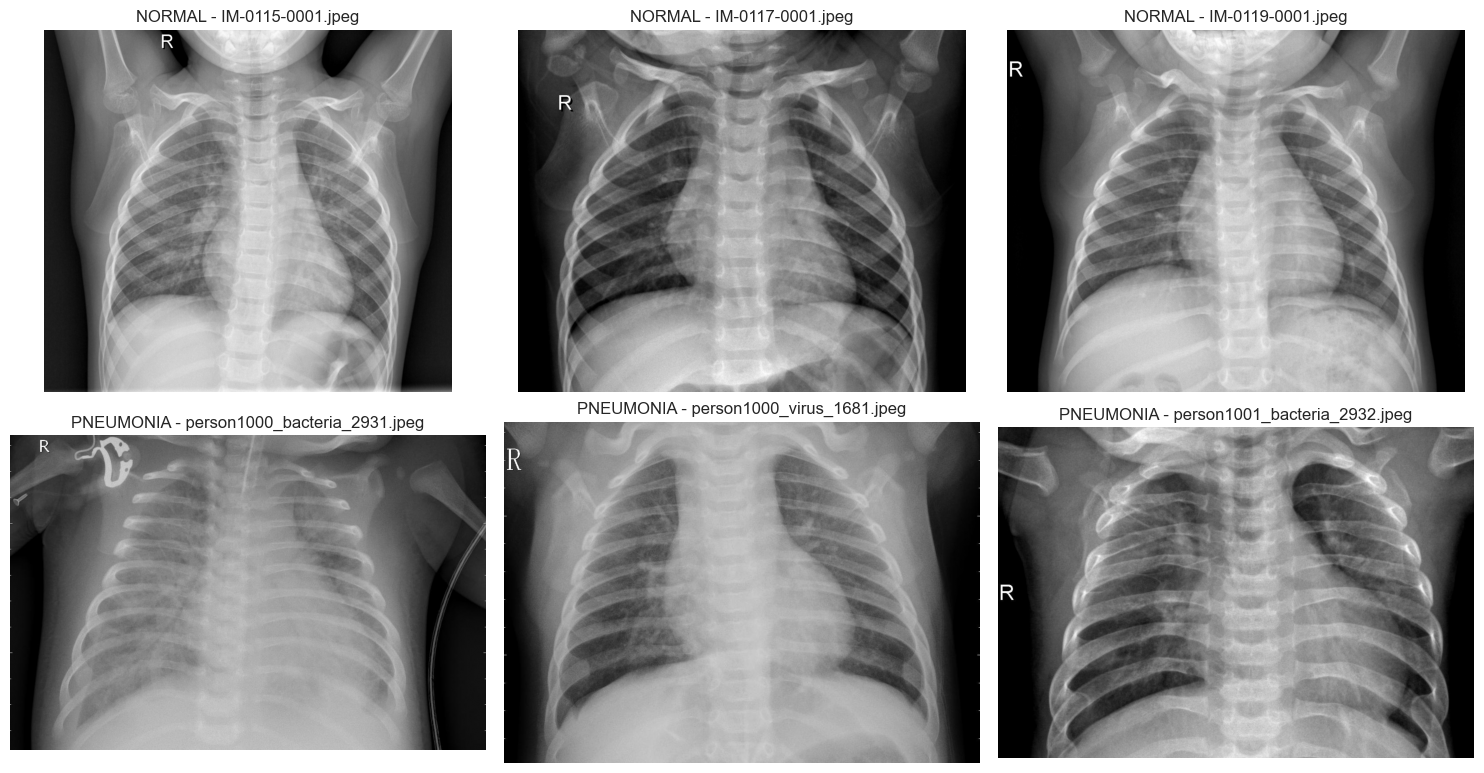

In [5]:
# Function to display sample images from each category (uses read_image_grayscale fallback)
def display_samples(path, split='train', num_samples=3):
    split_path = os.path.join(path, split)
    if not os.path.exists(split_path):
        print(f"Split path not found: {split_path}")
        return
    categories = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    if not categories:
        print(f"No category directories found under {split_path}")
        return

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 4 * len(categories)))

    for i, category in enumerate(categories):
        category_path = os.path.join(split_path, category)
        image_files = os.listdir(category_path)[:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(category_path, img_file)
            try:
                img = read_image_grayscale(img_path)
            except Exception as e:
                print(f"Failed reading {img_path}: {e}")
                img = None

            # Normalize axes indexing for single-row or single-column layouts
            if len(categories) == 1:
                ax = axes[j] if num_samples > 1 else axes
            else:
                ax = axes[i, j] if num_samples > 1 else axes[i]

            if img is None:
                ax.text(0.5, 0.5, 'Failed to load', ha='center')
            else:
                ax.imshow(img, cmap='gray')
            ax.set_title(f"{category} - {img_file}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from the training set
display_samples(nih_path, split='train')

## 3. Image Preprocessing and Augmentation

Let's define functions for preprocessing and augmenting the chest X-ray images.

In [6]:
# Define image transformations for training and validation/testing
# For grayscale images, torchvision transforms expect 1-channel tensors; we handle this by
# converting PIL grayscale images to 'L' and then to a single-channel tensor in transforms.
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, RandomAffine, ToTensor, Normalize

def get_transforms(phase):
    if phase == 'train':
        return Compose([
            Resize((224, 224)),
            RandomHorizontalFlip(),
            RandomRotation(10),
            RandomAffine(degrees=0, translate=(0.05, 0.05)),
            ToTensor(),  # converts PIL Image (L) to tensor with shape [1,H,W]
            Normalize(mean=[0.485], std=[0.229])
        ])
    else:  # 'val' or 'test'
        return Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=[0.485], std=[0.229])
        ])

In [7]:
# Create a custom dataset class for the NIH Chest X-ray dataset
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_name))
                self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
# Create datasets and dataloaders
train_transform = get_transforms('train')
val_transform = get_transforms('val')
test_transform = get_transforms('test')

train_dataset = ChestXrayDataset(nih_path, split='train', transform=train_transform)
val_dataset = ChestXrayDataset(nih_path, split='val', transform=val_transform)
test_dataset = ChestXrayDataset(nih_path, split='test', transform=test_transform)

batch_size = 32

# Use 0 workers on Windows by default to avoid multiprocessing deadlocks during development.
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")
print(f"Classes: {train_dataset.classes}")

Training set: 5216 images
Validation set: 16 images
Test set: 624 images
Classes: ['NORMAL', 'PNEUMONIA']


## 4. Visualizing Transformed Images

Let's visualize some transformed images to ensure our preprocessing pipeline is working correctly.

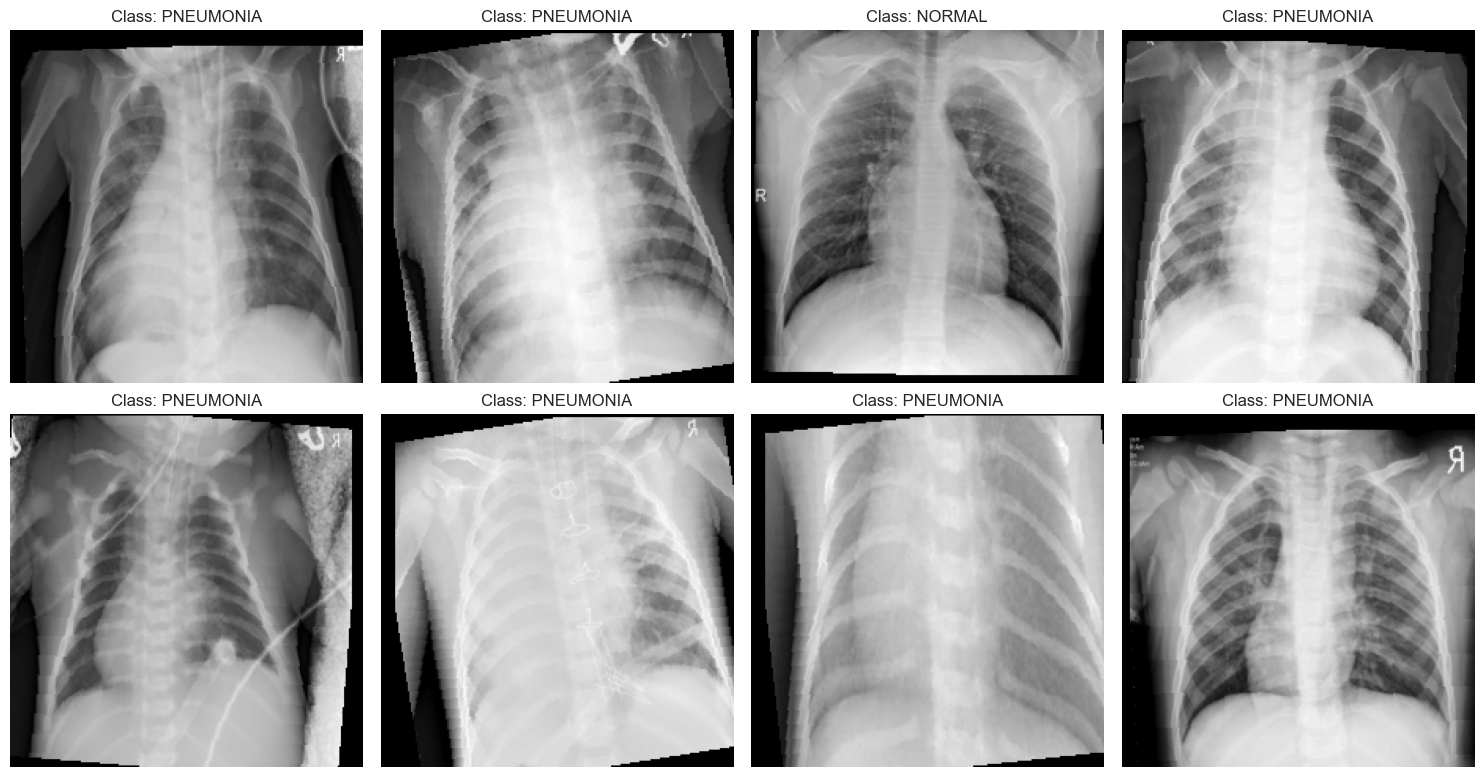

In [9]:
# Function to denormalize images for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485]).view(1, 1, 1)
    std = torch.tensor([0.229]).view(1, 1, 1)
    return tensor * std + mean

# Get a batch of training images
images, labels = next(iter(train_loader))

# Display a few transformed images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(8):
    img = denormalize(images[i])
    img = img.squeeze().numpy()
    label = labels[i].item()
    class_name = train_dataset.classes[label]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 5. Save Processed Data

Let's save the dataset information for use in our modeling notebooks.

In [10]:
# Create directory if it doesn't exist
os.makedirs('../src/data/processed', exist_ok=True)

# Save dataset information
dataset_info = {
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'classes': train_dataset.classes,
    'class_to_idx': train_dataset.class_to_idx,
    'image_size': (224, 224),
    'batch_size': batch_size
}

import json
with open('../src/data/processed/nih_dataset_info.json', 'w') as f:
    json.dump(dataset_info, f)

print("Dataset information saved successfully!")

Dataset information saved successfully!


In [11]:
# Save the dataset class and transforms for reuse in modeling notebooks
import pickle

# Save transforms
transforms_dict = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

with open('../src/data/processed/nih_transforms.pkl', 'wb') as f:
    pickle.dump(transforms_dict, f)

# Create a helper module with the dataset class
with open('../src/data/nih_dataset.py', 'w') as f:
    f.write("""
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_name))
                self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
""")

print("Dataset class saved successfully!")

Dataset class saved successfully!


## 6. Next Steps

Now that we have preprocessed the NIH Chest X-ray dataset, we can use this data for various modeling tasks:

1. **CNN Models**: Train convolutional neural networks for pneumonia detection
2. **Transfer Learning**: Fine-tune pre-trained models like ResNet, DenseNet, or EfficientNet
3. **Model Evaluation**: Evaluate models using metrics like accuracy, precision, recall, F1-score, and AUC-ROC
4. **Visualization**: Use techniques like Grad-CAM to visualize model attention

These models will be implemented in separate notebooks.